In [ ]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from classic_mil import Feature_attention
from sklearn.metrics import auc, roc_auc_score, roc_curve, mean_squared_error
from sklearn.metrics import precision_recall_curve, average_precision_score, cohen_kappa_score
from sklearn.preprocessing import label_binarize
#from sklearn.metrics import auc as calc_auc
from sklearn.utils import resample
import random
import glob
import h5py

from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import classification_report

from matplotlib import patches

import copy
import torchvision.transforms as transforms

from omegaconf import OmegaConf

## LOAD VALIDATION CONFIG AND CORRESPONDING CONFIG FILE FROM TRAINING ON THE PALTFORM!

In [2]:
conf_preproc = OmegaConf.load("../../conf/preproc.yaml")
conf_preproc = conf_preproc["classic_mil_on_embeddings_bag"]["jmcs_224_224_patches"]

conf_train = OmegaConf.load("sote_conf_train_rev.yaml")

In [3]:
if torch.cuda.is_available():
    DEVICE = 'cuda:0' 
else:
    DEVICE = 'cpu'
print("Device:", DEVICE)

Device: cuda:0


## Load models

In [4]:
best_models_on_val_loss = np.array(glob.glob("saved_sote_models_uni_finetuned_val_loss_rev/*.pt"))
#best_models_on_val_auc = np.array(glob.glob("saved_sote_models_uni_finetuned_val_auc_rev/*.pt"))

In [5]:
best_models_on_val_loss
#best_models_on_val_auc

array(['saved_sote_models_uni_finetuned_val_loss_rev/epoch_9_trainloss_0.651_valloss_0.652_auc_0.628_0.7_0.677_0.507_checkpoint.pt',
       'saved_sote_models_uni_finetuned_val_loss_rev/epoch_15_trainloss_0.607_valloss_0.613_auc_0.644_0.726_0.639_0.569_checkpoint.pt',
       'saved_sote_models_uni_finetuned_val_loss_rev/epoch_31_trainloss_0.509_valloss_0.544_auc_0.712_0.767_0.626_0.743_checkpoint.pt',
       'saved_sote_models_uni_finetuned_val_loss_rev/epoch_24_trainloss_0.564_valloss_0.614_auc_0.671_0.75_0.717_0.546_checkpoint.pt',
       'saved_sote_models_uni_finetuned_val_loss_rev/epoch_39_trainloss_0.429_valloss_0.492_auc_0.769_0.894_0.71_0.702_checkpoint.pt'],
      dtype='<U125')

In [6]:
np.mean([float(e.split('_auc_')[-1].split("_")[0]) for e in best_models_on_val_loss])
#np.mean([float(e.split('_auc_')[-1].split("_")[0]) for e in best_models_on_val_auc])

np.float64(0.6848000000000001)

## Load biopsy bags -> input data

In [ ]:
conf_preproc.uni_finetuned_biopsy_dir_macenko_improved_v2_patients_excluded_slides_cluster_tsne_1_2_3_rev

In [ ]:
biopsy_bag_input_path = conf_preproc.uni_finetuned_biopsy_dir_macenko_improved_v2_patients_excluded_slides_cluster_tsne_1_2_3_rev

biopsy_df_local_test = pd.read_csv("../../cv_splits_paper/cv_splits_multi_stratified_sklearn_s_a_r_mo_paper_patients_rev/final_df_with_excluded_slides_cluster_tsne_1_2_3.csv")
biopsy_df_local_test.sort_values('patient_ngsci_id', inplace=True)
biopsy_bag_input_files_local_test = np.array( sorted([ biopsy_bag_input_path+i+'.h5' for i in biopsy_df_local_test.patient_ngsci_id.values ]) )

biopsy_bag_input_files_local_test.shape, biopsy_bag_input_files_local_test[:3]

## Predict with MIL model ensemble

In [9]:
def load_h5_file_biopsy_bag(filename):
    with h5py.File(filename, "r") as f:
        features = f['features'][()]
        coords = f['coords'][()]
        slides = f['slides'][()]
        label = f['label'][()]
        return features, coords, slides, label

In [10]:
def plot_roc(y_true, y_pred):
    if y_pred.shape != y_true.shape:
        # try to one-hot encode y_true
        y_true = F.one_hot(torch.from_numpy(y_true).to(torch.int64), 4).numpy()

    plt.figure(figsize=(6, 6))
    auc_all = []
    for class_ind in range(y_pred.shape[-1]):
        if np.sum(y_true[:, class_ind]) == 0:
            print(f"Skipping class {class_ind + 1} as it is not present in y_true")
            continue

        fpr, tpr, _ = roc_curve(y_true[:, class_ind], y_pred[:, class_ind])
        auc = roc_auc_score(y_true[:, class_ind], y_pred[:, class_ind])
        auc_all.append(auc)
        plt.plot(fpr, tpr, '-', label='AUC : %.3f, label : %d' % (auc, class_ind + 1))

    plt.legend()
    plt.show()
    return auc_all

In [11]:
def plot_precision_recall(y_true, y_pred):
    if y_pred.shape != y_true.shape:
        # One-hot encode y_true
        y_true = label_binarize(y_true, classes=range(y_pred.shape[-1]))

    plt.figure(figsize=(6, 6))
    ap_all = []
    for class_ind in range(y_pred.shape[-1]):
        precision, recall, _ = precision_recall_curve(y_true[:, class_ind], y_pred[:, class_ind])
        average_precision = average_precision_score(y_true[:, class_ind], y_pred[:, class_ind])
        ap_all.append(average_precision)
        plt.plot(recall, precision, '-', label='AP: %.3f, Label: %d' % (average_precision, class_ind))
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    return ap_all

In [12]:
def pred_with_one_model(model, biopsy_bag_input_files):

    logits_all = []
    preds_all = []
    labels_all = []
    att_weight_all = []

    for b in range(biopsy_bag_input_files.shape[0]):

        with torch.no_grad():
            
            emb_npy, coords, slides, labels = load_h5_file_biopsy_bag( biopsy_bag_input_files[b] )

            emb = torch.from_numpy(np.expand_dims(emb_npy, 0).astype(np.float32)).to(DEVICE)
            logits, preds, label, att_weight = model(emb)

        
        logits_all.append(logits.cpu().detach().numpy())
        preds_all.append(preds.cpu().detach().numpy())
        labels_all.append(label.cpu().numpy())
        att_weight_all.append(att_weight.cpu().numpy().flatten())

    logits_all = np.concatenate(logits_all)
    preds_all = np.concatenate(preds_all)
    labels_all = np.concatenate(labels_all)
    att_weight_all = np.concatenate(att_weight_all)
    
    return logits_all, preds_all, att_weight_all, labels_all

### Whole NG cohort

In [13]:
best_models_on_selected_metric = best_models_on_val_loss

#best_models_on_selected_metric = best_models_on_val_auc

In [14]:
best_models_on_selected_metric

array(['saved_sote_models_uni_finetuned_val_loss_rev/epoch_9_trainloss_0.651_valloss_0.652_auc_0.628_0.7_0.677_0.507_checkpoint.pt',
       'saved_sote_models_uni_finetuned_val_loss_rev/epoch_15_trainloss_0.607_valloss_0.613_auc_0.644_0.726_0.639_0.569_checkpoint.pt',
       'saved_sote_models_uni_finetuned_val_loss_rev/epoch_31_trainloss_0.509_valloss_0.544_auc_0.712_0.767_0.626_0.743_checkpoint.pt',
       'saved_sote_models_uni_finetuned_val_loss_rev/epoch_24_trainloss_0.564_valloss_0.614_auc_0.671_0.75_0.717_0.546_checkpoint.pt',
       'saved_sote_models_uni_finetuned_val_loss_rev/epoch_39_trainloss_0.429_valloss_0.492_auc_0.769_0.894_0.71_0.702_checkpoint.pt'],
      dtype='<U125')

In [15]:
cuda_nr = 0
device=torch.device(f"cuda:{cuda_nr}" if torch.cuda.is_available() else "cpu")

nr_models = best_models_on_selected_metric.shape[0]

logits_ensemble_local_test = np.zeros((best_models_on_selected_metric.shape[0], biopsy_bag_input_files_local_test.shape[0], 3))
preds_ensemble_local_test = np.zeros((best_models_on_selected_metric.shape[0], biopsy_bag_input_files_local_test.shape[0], 3))
att_weights_local_test = [] # np.zeros((best_models_on_selected_metric.shape[0], biopsy_bag_input_files_local_test.shape[0], 1), dtype=object)


for m in tqdm(range(nr_models)):
    
    model = Feature_attention( conf_train.emb_dim, 
                               conf_train.hidden_dim, 
                               conf_train.att_hidden_dim,
                               conf_train.dropout_fc,
                               conf_train.dropout_attn, 
                               conf_train.n_classes).to(device)
    best_model_path = best_models_on_selected_metric[m] # path of the m th best model
    #print(os.path.basename(best_model_path))
    model_state_dict = torch.load(best_model_path, map_location=torch.device('cpu'), weights_only=True) # load

    model.load_state_dict(model_state_dict) # load weights
    model.eval() # set to eval mode ! 
    model.to(DEVICE)
    
    logits_all, preds_all, att_weights_all, _ = pred_with_one_model(model, biopsy_bag_input_files_local_test)

    logits_ensemble_local_test[m] = logits_all
    preds_ensemble_local_test[m] = preds_all
    att_weights_local_test.append(att_weights_all)
    
att_weights_local_test = np.array( att_weights_local_test, dtype=object)

100%|██████████| 5/5 [03:22<00:00, 40.46s/it]


In [16]:
logits_ensemble_local_test.shape, preds_ensemble_local_test.shape,  att_weights_local_test.shape

((5, 574, 3), (5, 574, 3), (5, 2058794))

In [17]:
np.save(f'preds_sote_5ensemble_level4_macenko_uni_finetuned_run_sote_sqrt_paper_rev_tuned_val_loss_NG_cohort_excluded_slides_cluster_tsne_1_2_3_rev.npy', preds_ensemble_local_test)

In [18]:
preds_ensemble_local_test = np.load('preds_sote_5ensemble_level4_macenko_uni_finetuned_run_sote_sqrt_paper_rev_tuned_val_loss_NG_cohort_excluded_slides_cluster_tsne_1_2_3_rev.npy')

#### Simple mean

In [19]:
final_pred_ensemble_local_test = np.mean(preds_ensemble_local_test, axis=0)
final_pred_ensemble_local_test.shape

(574, 3)

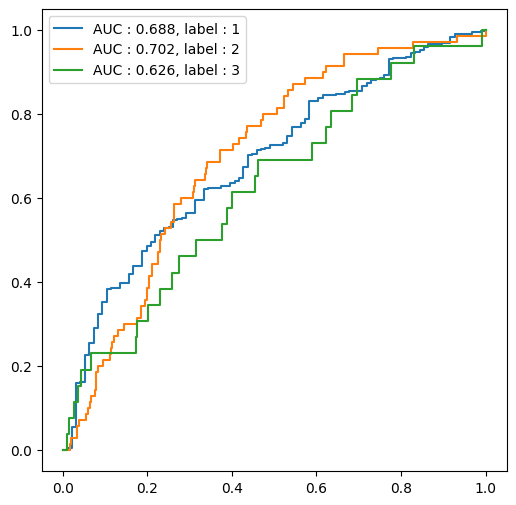

0.6717138112341449


In [20]:
auc_all = plot_roc( biopsy_df_local_test.Pathological.values-1, final_pred_ensemble_local_test  )
print( np.mean(auc_all) )

In [21]:
roc_auc_score( biopsy_df_local_test.Pathological.values-1, final_pred_ensemble_local_test, average="macro",  multi_class='ovr')

0.6717138112341449

In [22]:
roc_auc_score( biopsy_df_local_test.Pathological.values-1, final_pred_ensemble_local_test, average="weighted",  multi_class='ovr')

0.6864455651110958

(array([ 66., 123., 101.,  67.,  57.,  62.,  46.,  31.,  17.,   4.]),
 array([0.17189102, 0.2118653 , 0.25183958, 0.29181386, 0.33178814,
        0.37176242, 0.4117367 , 0.45171098, 0.49168526, 0.53165954,
        0.57163382]),
 <BarContainer object of 10 artists>)

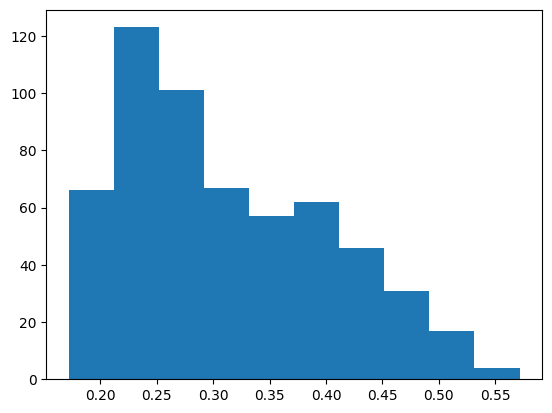

In [23]:
plt.hist(final_pred_ensemble_local_test[:,2])